# Custom Object Detection

The Custom Vision service is one of more than 20 services and APIs that make up Azure Cognitive Services. Cognitive Services enable you to build intelligence into your apps without requiring deep expertise in machine learning and AI. The Custom Vision service lets you build image-classification models and object-detection models and train them in the cloud on GPUs. When training is complete, you can either deploy the models as Web services and call them using REST APIs, or you can download them and consume them locally. Included in the download are sample source-code files demonstrating how to consume the model.

The following example uses a sea-turtle detector created with the Custom Vision service. Most of the code lives in **object_detection.py**, which was included in the download from the Custom Vision service.

In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from object_detection import ObjectDetection
from PIL import Image
import numpy as np

class SeaTurtleDetector(ObjectDetection):
    def __init__(self, graph_def, labels):
        super(SeaTurtleDetector, self).__init__(labels)
        self.graph = tf.compat.v1.Graph()
        with self.graph.as_default():
            input_data = tf.compat.v1.placeholder(tf.float32, [1, None, None, 3],
                                                  name='Placeholder')
            tf.import_graph_def(graph_def, input_map={"Placeholder:0": input_data},
                                name="")

    def predict(self, preprocessed_image):
        inputs = np.array(preprocessed_image, dtype=float)[:, :, (2, 1, 0)]

        with tf.compat.v1.Session(graph=self.graph) as sess:
            output_tensor = sess.graph.get_tensor_by_name('model_outputs:0')
            outputs = sess.run(output_tensor,
                               {'Placeholder:0': inputs[np.newaxis, ...]})
            return outputs[0]

def annotate_image(image, predictions, min_score=0.7, figsize=(12, 8)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'xticks': [], 'yticks': []})
    img_width, img_height = image.size
    ax.imshow(image)

    for p in predictions:
        score = p['probability']

        if score >= min_score: 
            x1 = p['boundingBox']['left'] * img_width
            y1 = p['boundingBox']['top'] * img_height
            width = p['boundingBox']['width'] * img_width
            height = p['boundingBox']['height'] * img_height
            label = p['tagName']

            rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=2)
            ax.add_patch(rect)
            label = f'{label} ({score:.0%})'
            ax.text(x1 + (width / 2), y1, label, color='white',
                    backgroundcolor='red', ha='center', va='bottom',
                    fontweight='bold', bbox=dict(color='red'))

Now create an instance of the model using the weights arrived at when it was trained by the Custom Vision service.

In [2]:
# Load the serialized model graph
graph_def = tf.compat.v1.GraphDef()
with tf.io.gfile.GFile('model.pb', 'rb') as f:
    graph_def.ParseFromString(f.read())

# Load the labels
with open('labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]

# Create the model
model = SeaTurtleDetector(graph_def, labels)

The final step is to submit an image to the model and see if it detects the sea turtle:

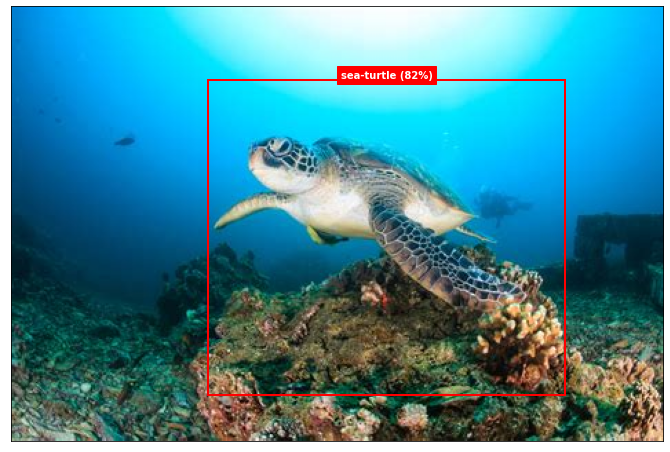

In [3]:
%matplotlib inline

image = Image.open('Data/sea-turtle.jpg')
predictions = model.predict_image(image)
annotate_image(image, predictions)

State-of-the art accuracy in object detection comes from training with lots of images. The 50 this model was trained with are a good start, but to train a model to a sufficient level of accuracy for real-world applications, you’ll probably need a minimum of 10 times more. The good news is that once you’ve compiled the images, the Custom Vision service makes it relatively easy to build and train the model.